### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [1]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

import cv2
from shapely.geometry import LineString
import time

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [2]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


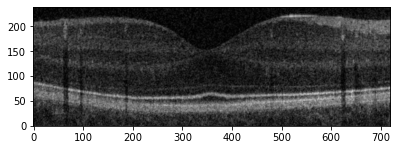

In [3]:
# Read, crop and display image and stats
def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [4]:
import time

start_time = time.time()
function_times = {}

def measure_time(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        function_time = te - ts
        
        if f.__name__ not in function_times:
            function_times[f.__name__] = [0, 0]  # [total_time, call_count]
        function_times[f.__name__][0] += function_time
        function_times[f.__name__][1] += 1
        
        return result
    
    return timed

def print_function_times():
    end_time = time.time()
    total_program_time = end_time - start_time
    
    print()
    print("### PROFILING ###")
    print("Total program time: {:.2f} sec".format(total_program_time))
    print("Function times:")
    for function_name, (total_time, call_count) in function_times.items():
        percentage = (total_time / total_program_time) * 100
        average_time = total_time / call_count
        print("- {}: {:.2f} sec ({:.2f}%), {} calls".format(
            function_name, total_time, percentage, call_count, average_time))
    print()

In [5]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def bezier_tangent(self, t):
        P0, P1, P2 = self.control_points()
        return 2 * (1 - t) * (P1 - P0) + 2 * t * (P2 - P1)
    
    @measure_time
    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        height, width = image.shape[:2]
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, width - 1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, height - 1)
        colours = [image[point[1],point[0]] for point in intermediates] #? had to swap point[1] and point[0] cause y and x were in the other order
        return(np.array(colours)/255)
    
    @measure_time
    def img_colour_at_w(self, image, t_values=[0, 0.5, 1]):
        width_points = []
        for t in t_values:
            # Calculate the point on the bezier curve
            base_point = self.bezier.point_at_t(t)
            # Calculate the tangent at this point
            tangent = self.bezier_tangent(t)
            # Normalize the tangent vector
            tangent_norm = tangent / np.linalg.norm(tangent)
            # Calculate the normal (perpendicular) to the tangent
            normal = np.array([-tangent_norm[1], tangent_norm[0]])
            # Calculate points across the width of the worm
            half_width = self.width 
            if t in [0, 1]:  # Only at the tips
                # Points perpendicular to the path
                points_at_t = [
                    base_point + normal * half_width * i
                    for i in [-1, 1]  # Left and right side of the worm
                ]
                # Points tangent to the path
                if t == 0:
                    points_tangent = [
                        base_point + tangent_norm * half_width * -1 # Backward along the tangent
                    ]
                else:
                    points_tangent = [
                        base_point + tangent_norm * half_width * 1 # forward along the tangent
                    ]
                width_points.extend(points_at_t)
                width_points.extend(points_tangent)
            else:
                # Middle points, just the normal ones
                points_at_t = [
                    base_point + normal * half_width * i
                    for i in [-1, 1]  # Left and right side
                ]
                width_points.extend(points_at_t)
        intermediates = np.int64(np.round(np.array(width_points)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t_values))])

    @measure_time
    def img_color_across_t(self, t, image):
        # average image colour across all points in t 
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t))])

In [6]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms, alpha=1.0, colour=None):
        colourmap = mpl.colormaps["rainbow"]
        try:
            for worm in worms:
                patch = worm.patch()
                patch.set_alpha(alpha)
                if colour != None:
                    patch.set_edgecolor(colourmap(colour))
                self.ax.add_patch(patch)
        except TypeError:
            patch = worms.patch()
            patch.set_alpha(alpha)
            if colour != None:
                patch.set_edgecolor(colourmap(colour))
            self.ax.add_patch(patch)

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [7]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [8]:
# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

In [31]:
class Fitness:
    def __init__(self, image, swarms):
        self.image = image
        self.swarms = swarms
        self.times = {}
        
    @measure_time
    def get(self, worm):
        img_height, img_width = self.image.shape[:2]

        # obtain internal score
        def internal_fitness():
            @measure_time
            # width factor
            def width():
                # example weakly encouraging width to be 8
                return (1 / max(abs(worm.width - 5),1),5) 

            @measure_time
            # length factor
            def length():
                # provides benefit up to a value of img_width/8 then no more benefit
                if worm.r < 5:
                    return (0,0)
                return (1,1)

            internal_factors = [width(), length()]
            return sum([x[0] * x[1] for x in internal_factors])

        # obtain group score
        def group_fitness():
            @measure_time
            # distance between swarms
            def worm_spread():
                closest_worm = None
                min_distance = float('inf')  # Initialize with a large number
                avgs = []
                # Iterate through each swarm and each worm within the swarm
                for s in swarms:
                    if s in swarms[::len(swarms)//10]:
                        avgs.append(s.population[0])
                    if worm not in s.population:  # Ensure not checking the worm's own swarm
                        other_worm = s.population[0]
                        # Calculate Euclidean distance
                        distance = ((worm.x - other_worm.x) ** 2 + (worm.y - other_worm.y) ** 2) ** 0.5
                        if distance < min_distance:
                            min_distance = distance
                            closest_worm = other_worm  # Update the closest worm
                # Apply upper limit to distance based on image dimensions and number of swarms
                distance_limit = min(min_distance, min(img_width, img_height) * 2 / np.ceil(len(swarms) ** 0.5))
                # Normalize the distance
                normalized_distance = distance_limit / (min(img_width, img_height) / np.ceil(len(swarms) ** 0.5))
                return (normalized_distance, 1.2, closest_worm, avgs)
        
            # detect if the worm is crossing another, penalise heavily
            @measure_time
            def cross_factor(avgs):
                line1 = LineString(worm.path().vertices)
                for other_worm in avgs:
                    line2 = LineString(other_worm.path().vertices)
                    # Check if the lines intersect and that the intersection is not just touching
                    if line1.intersects(line2) and not line1.touches(line2):
                        return (-1,5)
                return (0,0)

            # detect if the worm is roughly parallel with its closest friend
            @measure_time
            def parallelism(closest_worm):
                r1 = worm.theta
                r2 = closest_worm.theta
                angle_diff = np.abs(r1 - r2)
                angle_diff = min(angle_diff, 2*np.pi - angle_diff)  # This accounts for wrapping around the circle
                # Normalize the difference to a score from 0 to 1
                # Maximum difference that affects parallelism is pi (180 degrees)
                similarity_score = 1 - (angle_diff / np.pi)  # Normalize the difference by pi
                return (similarity_score,0.15)

            worm_spread = worm_spread()
            group_factors = [worm_spread, cross_factor(worm_spread[3]), parallelism(worm_spread[2])]
            return sum([x[0] * x[1] for x in group_factors])

        # obtain environmental score
        def environmental_fitness():
            @measure_time
            # colour factor
            def colour():
                DIVISIONS = 10
                # points along centre path 
                t = np.linspace(0,1,DIVISIONS)
                path_colour = worm.img_color_across_t(t, self.image)
                width_colour = worm.img_colour_at_w(self.image)
                ps = 1 - np.mean(np.abs(worm.colour - path_colour))
                # ws = 1 - np.mean(np.abs(worm.colour - width_colour))
                # subtract from 1 since higher fitness is better
                return (ps, 5)
                
            @measure_time
            # discourage from going out of bounds
            def outside():
                min_x, min_y = np.min(worm.control_points(), axis=0)
                max_x, max_y = np.max(worm.control_points(), axis=0)
                if min_x < 0 or max_x >= img_width or min_y < 0 or max_y >= img_height:
                    return (-1, 10)  # high cost for going outside
                else:
                    return (0, 0) # doesn't affect worm if it's inside boundaries

            environmental_factors = [colour(), outside()]
            return sum([x[0] * x[1] for x in environmental_factors])

        # driver weights
        Wi = 1
        Wg = 1
        We = 1
        # driver costs
        Ci = internal_fitness()
        Cg = group_fitness()
        Ce = environmental_fitness()
        # implement cost/fitness function
        fitness = (Wi*Ci) + (Wg*Cg) + (We*Ce)
        return fitness

In [10]:
import random, copy
"""
Each Swarm represents a single worm 
"""
class Swarm:
    def __init__ (self, image, population):
        self.image = image
        self.population = population
        self.fitness = None # must be updated after Fitness class is created
        
        # CONSTANTS #
        
        # number of individuals in the selection tournament
        # a higher tnm_k means it will select more of the best, and less of the worst
        # may converge faster without as much exploration
        self.tnm_k = 3
        
        # rate of mutation which should be between 0 and 1
        # a high rate may prevent convergence, a low rate will need more iterations to converge
        self.m_rate = 0.01 
        
    @measure_time
    def update(self):
        assert(self.fitness != None)
        fitnesses = [fitness.get(x) for x in self.population]
        new_population = []
        size = len(self.population)
        for i in range(size):
            # tournament selection
            selected_ix = random.randint(0,size-1)
            for ix in [random.randint(0,size-1) for x in range(self.tnm_k-1)]:
                if fitnesses[ix] > fitnesses[selected_ix]:
                    selected_ix = ix
            parent = self.population[selected_ix]
            # mutating
            height, width = image.shape[:2]
            c_x = min(max(parent.x + random.uniform(-self.m_rate*width/2,self.m_rate*width/2),0),width)
            c_y = min(max(parent.y + random.uniform(-self.m_rate*height/2,self.m_rate*height/2),0),height)
            max_r = max(width,height)/2
            c_r = min(max(parent.r + random.uniform(-self.m_rate*max_r/2,self.m_rate*max_r/2),0),max_r)
            c_colour = min(max(parent.colour + random.uniform(-self.m_rate/2,self.m_rate/2),0),1)
            c_theta = (parent.theta + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi)) % (np.pi*2)
            c_dr = min(max(parent.dr + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),-c_r),c_r)
            c_dgamma = min(max(parent.dgamma + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi),-np.pi),np.pi)
            c_width = min(max(parent.width + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),1),2*c_r)
            # child
            child = Camo_Worm(c_x, c_y, c_r, c_theta, c_dr, c_dgamma, c_width, c_colour)
            new_population.append(child)
        self.population = new_population
    @measure_time
    def avg_worm(self):
        avg = copy.deepcopy(self.population[0])
        for field in ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width']:
            setattr(avg, field, np.mean([getattr(w, field) for w in self.population]))
        return avg
    

C:\Users\calsp\AppData\Local\Temp\ipykernel_44004\2238234594.py:57: RuntimeWarning: invalid value encountered in divide
  tangent_norm = tangent / np.linalg.norm(tangent)
C:\Users\calsp\AppData\Local\Temp\ipykernel_44004\2238234594.py:86: RuntimeWarning: invalid value encountered in cast
  intermediates = np.int64(np.round(np.array(width_points)))


Iteration: 1
Time Remaining: 237 seconds
Fitness: [6.65, 4.27, 9.22, 6.7, 7.86, 3.64, 5.98, 6.43, 8.47, 4.11, 4.82, 7.29, 7.62, 4.56, 8.48, 5.51, 8.12, 5.82, 6.96, 6.79, 5.59, 4.21, 5.41, 8.92, 8.13, 5.48, 6.93, 5.58, 5.59, 4.58, 4.38, 4.49, 6.92, 7.8, 5.72, 7.24, 5.44, 8.91, 7.1, 7.86, 4.19, 7.36, 6.84, 3.45, 7.56, 6.88, 6.63, 5.38, 5.35, 6.85, 4.71, 6.16, 8.63, 5.21, 5.6, 6.79, 6.18, 6.99, 7.57, 6.68, 8.74, 5.71, 6.72, 4.15, 5.1, 6.19, 7.23, 8.25, 7.47, 3.89, 7.21, 5.81, 5.1, 5.62, 8.12, 7.11, 2.88, 5.42, 3.31, 6.95, 6.79, 6.46, 9.39, 7.55, 6.95, 6.28, 7.8, 6.28, 5.98, 4.86, 7.04, 5.56, 6.15, 5.76, 4.73, 7.5, 6.72, 7.16, 3.9, 5.85]
Mutation Rate: 0.1
Tournament Size: 2

### PROFILING ###
Total program time: 1.19 sec
Function times:
- width: 0.00 sec (0.08%), 2000 calls
- length: 0.00 sec (0.00%), 2000 calls
- worm_spread: 0.21 sec (17.81%), 2000 calls
- cross_factor: 0.50 sec (41.79%), 2000 calls
- parallelism: 0.01 sec (0.81%), 2000 calls
- img_color_across_t: 0.07 sec (6.27%), 2000

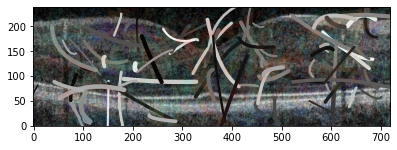


Iteration: 20
Time Remaining: 136 seconds
Fitness: [7.7, 7.38, 11.6, 9.03, 9.85, 7.63, 8.76, 9.23, 9.62, 8.44, 6.35, 10.3, 9.47, 10.3, 8.0, 7.83, 9.47, 9.51, 10.0, 5.22, 5.7, 10.3, 10.6, 8.37, 10.7, 10.6, 9.9, 8.8, 7.78, 8.59, 8.81, 8.89, 7.78, 9.7, 9.91, 6.64, 6.76, 9.38, 9.26, 7.33, 9.05, 10.2, 11.0, 8.93, 8.85, 9.46, 9.66, 10.7, 8.04, 10.6, 8.9, 10.7, 10.2, 8.13, 7.08, 7.46, 9.03, 9.75, 9.32, 9.6, 9.76, 6.97, 8.79, 8.99, 5.83, 6.15, 4.24, 7.94, 8.52, 8.33, 9.21, 8.18, 9.86, 8.99, 8.85, 5.5, 6.55, 8.3, 6.62, 11.0, 6.89, 9.13, 9.15, 8.95, 9.1, 8.79, 10.1, 9.92, 6.55, 6.7, 7.33, 8.96, 10.3, 8.69, 8.62, 6.61, 8.46, 8.05, 10.6, 9.68]
Mutation Rate: 0.0752
Tournament Size: 2

### PROFILING ###
Total program time: 15.19 sec
Function times:
- width: 0.02 sec (0.16%), 22000 calls
- length: 0.00 sec (0.03%), 22000 calls
- worm_spread: 2.41 sec (15.86%), 22000 calls
- cross_factor: 5.71 sec (37.59%), 22000 calls
- parallelism: 0.07 sec (0.48%), 22000 calls
- img_color_across_t: 0.79 sec (5.17

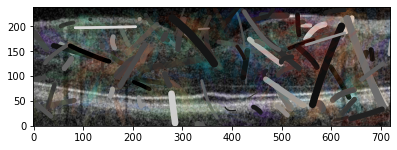


Iteration: 40
Time Remaining: 117 seconds
Fitness: [10.5, 6.35, 10.7, 11.1, 10.2, 9.54, 7.22, 9.79, 10.5, 6.37, 8.49, 9.07, 10.2, 10.9, 9.32, 7.28, 10.3, 12.0, 9.98, 8.74, 8.79, 10.8, 11.6, 10.0, 11.2, 10.9, 10.6, 8.96, 8.49, 11.5, 9.8, 10.4, 10.6, 11.6, 9.49, 11.6, 4.21, 9.64, 7.84, 10.2, 9.41, 11.5, 10.7, 10.8, 8.49, 10.6, 10.6, 11.3, 10.5, 8.76, 6.14, 11.4, 8.7, 10.1, 7.19, 10.4, 10.6, 9.23, 8.6, 11.1, 9.06, 9.44, 8.49, 9.56, 9.57, 8.94, 7.85, 10.4, 9.37, 11.3, 7.66, 10.8, 9.87, 7.23, 11.1, 9.55, 10.7, 9.46, 9.18, 10.3, 7.95, 8.96, 11.0, 11.1, 10.2, 9.37, 10.2, 9.92, 7.57, 8.77, 9.88, 11.0, 11.2, 9.51, 9.94, 9.04, 4.61, 9.19, 8.73, 8.96]
Mutation Rate: 0.0557
Tournament Size: 2

### PROFILING ###
Total program time: 29.38 sec
Function times:
- width: 0.05 sec (0.17%), 43000 calls
- length: 0.01 sec (0.05%), 43000 calls
- worm_spread: 4.68 sec (15.93%), 43000 calls
- cross_factor: 11.25 sec (38.28%), 43000 calls
- parallelism: 0.14 sec (0.48%), 43000 calls
- img_color_across_t: 1.51

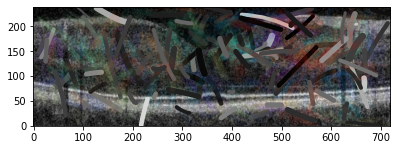


Iteration: 60
Time Remaining: 102 seconds
Fitness: [9.78, 9.96, 9.58, 12.1, 11.6, 11.0, 11.8, 12.0, 11.1, 7.63, 10.2, 10.1, 11.3, 11.5, 10.3, 11.1, 11.4, 11.3, 9.08, 11.7, 8.8, 11.1, 11.2, 9.24, 10.4, 10.2, 8.51, 10.8, 10.0, 9.05, 10.2, 11.1, 12.3, 11.5, 10.9, 11.3, 10.6, 10.7, 11.5, 11.0, 10.8, 11.6, 11.7, 11.4, 11.5, 10.5, 11.2, 9.83, 11.7, 11.0, 10.4, 11.7, 11.1, 10.6, 11.0, 10.2, 11.6, 10.5, 9.34, 11.3, 9.59, 9.6, 8.85, 11.1, 8.62, 10.5, 11.6, 11.6, 12.2, 10.8, 6.33, 12.3, 12.1, 10.7, 11.7, 7.51, 9.24, 11.6, 11.3, 9.8, 9.46, 11.3, 11.8, 11.6, 12.0, 8.26, 11.7, 12.1, 9.82, 9.66, 8.67, 12.3, 11.5, 11.2, 11.0, 11.4, 9.32, 10.6, 9.39, 11.4]
Mutation Rate: 0.0413
Tournament Size: 2

### PROFILING ###
Total program time: 43.89 sec
Function times:
- width: 0.08 sec (0.19%), 64000 calls
- length: 0.02 sec (0.06%), 64000 calls
- worm_spread: 6.96 sec (15.86%), 64000 calls
- cross_factor: 16.56 sec (37.74%), 64000 calls
- parallelism: 0.22 sec (0.51%), 64000 calls
- img_color_across_t: 2.30

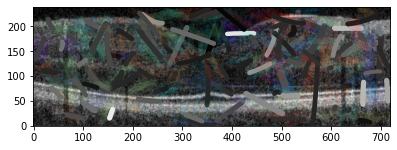

In [32]:
# for profiling
start_time = time.time()
function_times = {}
profiling = True # change to True to see function times
# constants
iterations = 200
swarm_size = 10
num_swarms = 100
swarms = [Swarm(image, initialise_clew(swarm_size, image.shape, (40, 30, 1))) for _ in range(num_swarms)]
fitness = Fitness(image, swarms)
for s in swarms:
    s.fitness = fitness
    #s.tnm_k = 4
    #s.m_rate = 0.02

for it in range(iterations):
    fitnesses = []
    for swarm in swarms:
        # start the mutation rate high for a short time then keep it low for a long time (exponential)
        # allows for fast exploration at the start with fine tuning of the final solution at the end
        swarm.m_rate = 0.1 * np.exp(-3 * (it / iterations)) # -3 growth rate so it quickly decreases
        # same principle with tournament size, except that it starts low and increases over time
        # if tournament size = population, all children will come from the best parent (no diversity)
        swarm.tnm_k = max(int(len(swarm.population) / (1+np.exp(-5 * (it/iterations-0.8)))+1), 2) 
        swarm.update()
    if (it+1) % (iterations//10) == 0 or int(it) == 0:
        all_fitnesses = [sum(x) / len(x) for x in [[fitness.get(w) for w in p.population] for p in swarms]]
        print("Iteration:",it+1)
        print("Time Remaining:",int((time.time() - start_time) / (it+1) * (iterations - (it+1))),"seconds")
        print("Fitness:",[float(f"{x:.3}") for x in all_fitnesses])
        print(f"Mutation Rate: {swarms[0].m_rate:.3}")
        print(f"Tournament Size: {swarms[0].tnm_k}")
        if profiling:
            print_function_times()
        drawing = Drawing(image)
        for ix in range(len(swarms)):
            drawing.add_worms(swarms[ix].population, alpha=0.05, colour=(ix/len(swarms)))
            drawing.add_worms(swarms[ix].avg_worm())
        drawing.show()
        print()
        
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm())
drawing.save("/images/final_image")
drawing.show()
plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')

Image name (shape) (intensity max, min, mean, std)

averaged (240, 720) (182, 5, 49.4, 32.4)


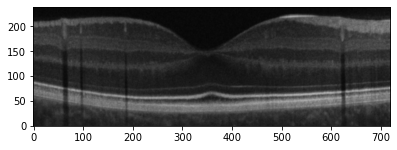

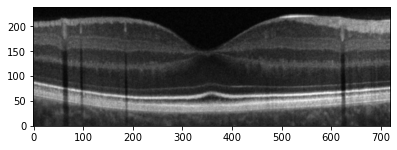

<Figure size 460.8x345.6 with 0 Axes>

Image variance: 0.046646641408580436


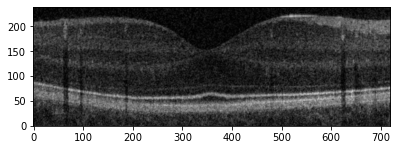

In [21]:
# returns a percentage similarity to the averaged original image
def image_variance(current_image, averaged_image):
    # Read the images
    current_image = cv2.imread(current_image_path, cv2.IMREAD_GRAYSCALE)
    averaged_image = cv2.imread(averaged_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if images are loaded successfully
    if current_image is None or averaged_image is None:
        print("Error: One or both images could not be loaded.")
        return None
    
    # Compute the squared difference between the images
    squared_diff = (current_image - averaged_image) ** 2
    
    # Compute the mean of the squared difference
    variance = np.mean(squared_diff)
    
    # Normalize variance by the maximum possible variance
    max_possible_variance = 255**2  # Maximum possible pixel value difference
    percentage_difference = (variance / max_possible_variance) * 100
    
    return percentage_difference

avg_image = prep_image(IMAGE_DIR, "averaged", MASK)
drawing = Drawing(avg_image)
drawing.show(save=("images/avg_comparison"))
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm())
drawing.show(save=("images/final"))
plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')
    
# Example usage:
current_image_path = "images/final.png"
averaged_image_path = "images/avg_comparison.png"
variance = image_variance(current_image_path, averaged_image_path)
print("Image variance:", variance)